In [ ]:
from google.colab import drive ; drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 890kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 16.7MB/s 
     |████████████████████████████████| 3.0MB 24.8MB/s 
     |████████████████████████████████| 890kB 44.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=fd585116b05ebf37427fb220247dcc8884a9a1dec3a7e3097250cd5720b46740
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import *
import seaborn as sns
pd.set_option("max_rows",None)
print(f"tensor_ver {tf.__version__}")

tensor_ver 2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_excel("/content/drive/My Drive/dataset_analisis.xlsx")
df = df[["list_text_after_stop_word"]]
df

,list_text_after_stop_word
0,merasakan pjj gaa suruh ngerjain tugas segambreng
1,pjj ip turun
2,pjj pjj tai anjing
3,woi malas pjj
4,oii ajarin tidur dibawah jam kg tidur anjing t...
5,a gila anjing pjj tidak masuk keotak
6,ngambis ujian tulis berbasis komputer tidak pjj
7,pjj tidak masuk otak
8,anjing bodoh pjj nilai uh remed
9,minus kayaknya nambah karena pjj deh


In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")

In [ ]:
def regular_encode(texts, tokenizer = tokenizer, maxlen=128):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        max_length=maxlen,
        return_attention_mask = True,
        return_token_type_ids = True,
        pad_to_max_length = True,
        truncation = True
    )
    return np.array(enc_di["input_ids"])
EncodedDataset = regular_encode(df["list_text_after_stop_word"].values)

EncodedDataset

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


array([[    0, 67989,   915, ...,     1,     1,     1],
       [    0,   915, 69136, ...,     1,     1,     1],
       [    0,   915, 69136, ...,     1,     1,     1],
       ...,
       [    0,   915, 69136, ...,     1,     1,     1],
       [    0,   770,  1772, ...,     1,     1,     1],
       [    0,    91,    71, ...,     1,     1,     1]])

In [ ]:
MAX_LEN = 128

In [ ]:
import keras
def main_model():
  config = XLMRobertaConfig.from_pretrained("jplu/tf-xlm-roberta-large")
  #config.num_labels = 2
  METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]  
  strategy = tf.distribute.get_strategy()

  with strategy.scope():
    ENCODER = TFAutoModel.from_pretrained("jplu/tf-xlm-roberta-large",config= config)
    input_ids = tf.keras.layers.Input(shape=(MAX_LEN), dtype=tf.int32)

    embedding, sequence_output = ENCODER(input_ids)
      #Disini Boleh Di adjust  
    logits = embedding[:,0,:]
    logits = tf.keras.layers.Dropout(0.8)(logits)
    logits = tf.keras.layers.Dense(512,tf.keras.layers.LeakyReLU())(logits)
    logits = tf.keras.layers.Dropout(0.4)(logits)
    logits = tf.keras.layers.Dense(16,tf.keras.layers.ReLU())(logits)
    logits = tf.keras.layers.Dropout(0.3)(logits)
    outputs = tf.keras.layers.Dense(units=2, activation='softmax')(logits)
    model = tf.keras.Model(inputs=input_ids, outputs=outputs)
    #optimizer = tf.keras.optimizers.SGD(lr=0.001,momentum=0.9)
    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    loss = tf.keras.losses.CategoricalCrossentropy()

    for layer in model.layers[:2]:
      layer.trainable = False

    model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)
  return model

model = main_model()
model.summary()

Some weights of the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo ((None, 128, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_75 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)               

In [ ]:
#model = main_model()
model.load_weights("/content/drive/My Drive/Gemastik/XLMRoberta/XLMROBERTA.h5")

In [ ]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((EncodedDataset))
    .batch(32)
    .cache()
)
ans = model.predict((test_dataset)).argmax(axis=-1)

In [ ]:
df["sentiment"] = ans

,list_text_after_stop_word,sentiment
0,merasakan pjj gaa suruh ngerjain tugas segambreng,0
1,pjj ip turun,0
2,pjj pjj tai anjing,0
3,woi malas pjj,0
4,oii ajarin tidur dibawah jam kg tidur anjing t...,0
5,a gila anjing pjj tidak masuk keotak,0
6,ngambis ujian tulis berbasis komputer tidak pjj,0
7,pjj tidak masuk otak,0
8,anjing bodoh pjj nilai uh remed,0
9,minus kayaknya nambah karena pjj deh,0


In [ ]:
Matanajwa = pd.read_excel("/content/drive/My Drive/Gemastik/XLMRoberta/mataNajwa.xlsx")
Matanajwa

,Unnamed: 0,no,text,list_text_after_stop_word,hasil_akhir_preprocessing
0,0,1,"['sial', 'belajarnya', 'menit', 'main', 'perma...",sial belajarnya menit main permainan lain-lain...,sial ajar menit main main lain nya jambayangin...
1,1,11,"['sekolah', 'tidak', 'pulsakuota', 'gratis', '...",sekolah tidak pulsakuota gratis sekolah,sekolah tidak pulsakuota gratis sekolah
2,2,2,"['mbak', 'nanatidak', 'pulsatolong', 'mentripj...",mbak nanatidak pulsatolong mentripjj tidak efe...,mbak nanatidak pulsatolong mentripjj tidak efe...
3,3,3,"['google', 'pandai', 'guru', 'guru', 'kasih', ...",google pandai guru guru kasih sayang mendidik ...,google pandai guru guru kasih sayang didik mur...
4,4,4,"['mbak', 'najwa', 'tolong', 'mas', 'nadiem', '...",mbak najwa tolong mas nadiem sekolah tidak kuo...,mbak najwa tolong mas nadiem sekolah tidak kuo...
5,5,5,"['sekolah', 'daring', 'mahasiswa', 'down']",sekolah daring mahasiswa down,sekolah daring mahasiswa down
6,6,6,"['guru', 'matematika', 'kelas', 'sd', 'menangi...",guru matematika kelas sd menangis kunjungi sis...,guru matematika kelas sd menang kunjung siswa tes
7,7,7,"['mas', 'menteri', 'sdh', 'berusaha', 'mmbantu...",mas menteri sdh berusaha mmbantu meringankan k...,mas menteri sdh usaha mmbantu ringan sulit mah...
8,8,8,"['kemendikbud', 'kolaborasi', 'kementrian', 'd...",kemendikbud kolaborasi kementrian desa wifi re...,kemendikbud kolaborasi tri desa wifi retweet m...
9,9,9,"['menggapai', 'pendidikan', 'edukasi', 'kurang...",menggapai pendidikan edukasi kurangi tayangan ...,gapai didik edukasi kurang tayang norak tvting...


In [ ]:
CNN = pd.read_excel("/content/drive/My Drive/Gemastik/XLMRoberta/CNN.xlsx")
CNN 

,Unnamed: 0,no,text,list_text_after_stop_word,hasil_akhir_preprocessing
0,0,1,"['tugas', 'tidak', 'signal', 'guru', 'rumah', ...",tugas tidak signal guru rumah siswa memebri tu...,tugas tidak signal guru rumah siswa memebri tu...
1,1,2,"['belajar', 'rumah', 'aturan', 'pemerintah', '...",belajar rumah aturan pemerintah pemerintah yng...,ajar rumah atur perintah perintah yng tanggung...
2,2,3,"['tidak', 'setuju', 'belajar', 'onlinekarna', ...",tidak setuju belajar onlinekarna lihat belajar...,tidak tuju ajar onlinekarna lihat ajar bukan a...
3,3,4,"['semoga', 'cepat', 'hilang', 'covid', 'semang...",semoga cepat hilang covid semangat belajarnya iya,moga cepat hilang covid semangat ajar iya
4,4,5,"['alhamdulillah', 'lulus', 'sekolah', 'langsun...",alhamdulillah lulus sekolah langsung intel,alhamdulillah lulus sekolah langsung intel
5,5,6,"['berjuang', 'kekurangan', 'patah', 'semangat'...",berjuang kekurangan patah semangat belajar,juang kurang patah semangat ajar
6,6,7,"['sekolah', 'serius', 'bukan', 'ngasi', 'tugas...",sekolah serius bukan ngasi tugas pemaparan tidak,sekolah serius bukan ngasi tugas papar tidak
7,7,8,"['bukti', 'anak', 'bangsa', 'kreatip', 'menyon...",bukti anak bangsa kreatip menyongsong industri...,bukti anak bangsa kreatip songsong industriali...
8,8,9,"['daerah', 'terpencil', 'boro', 'stasiun', 'tv...",daerah terpencil boro stasiun tvnyari sinyal a...,daerah pencil boro stasiun tvnyari sinyal aja ...
9,9,10,"['dung', 'pemerintah']",dung pemerintah,dung perintah


In [ ]:
EncodedNajwa =  regular_encode(Matanajwa["list_text_after_stop_word"].values)
EncodedCnn = regular_encode(CNN["list_text_after_stop_word"].values)

EncodedNajwa.shape , EncodedCnn.shape

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


((19, 128), (10, 128))

In [ ]:
test_dataset_Najwa= (
    tf.data.Dataset
    .from_tensor_slices((EncodedNajwa))
    .batch(32)
    .cache()
)
ans = model.predict((test_dataset_Najwa)).argmax(axis=-1)

In [ ]:
Matanajwa["sentiment"] = ans

In [ ]:
test_dataset_CNN= (
    tf.data.Dataset
    .from_tensor_slices((EncodedCnn))
    .batch(32)
    .cache()
)
ans = model.predict((test_dataset_CNN)).argmax(axis=-1)

In [ ]:
CNN["sentiment"] = ans

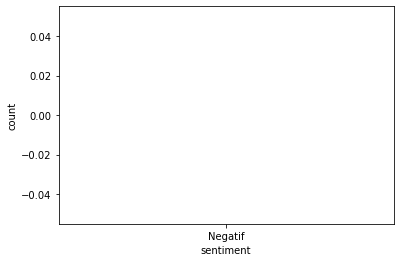

[Text(0, 0.5, 'Freq')]

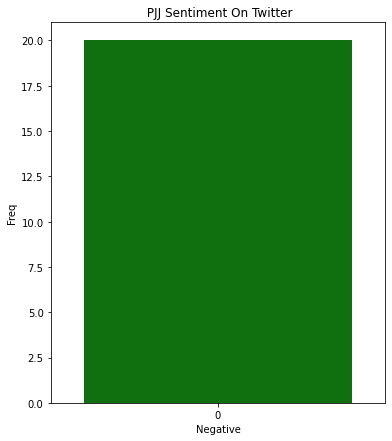

In [ ]:
fig,axes1 = plt.subplots(1,1,figsize=(6,7))
sns.countplot(x = "sentiment" , data = df,ax = axes1,color="green")
axes1.set(xlabel = "Negative") ; axes1.set(title = " PJJ Sentiment On Twitter") ; axes1.set(ylabel = "Freq")


[Text(0, 0.5, 'Freq')]

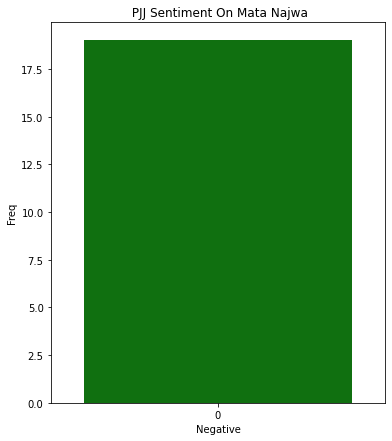

In [ ]:
fig,axes2 = plt.subplots(1,1,figsize=(6,7))
sns.countplot(x = "sentiment" , data = Matanajwa,ax = axes2,color="green")
axes2.set(xlabel = "Negative") ; axes2.set(title = " PJJ Sentiment On Mata Najwaz") ; axes2.set(ylabel = "Freq")



[Text(0, 0.5, 'Freq')]

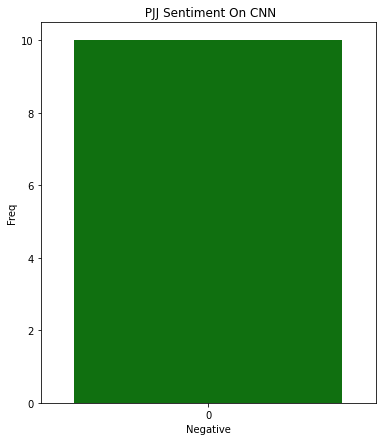

In [ ]:
fig,axes3 = plt.subplots(1,1,figsize=(6,7))
sns.countplot(x = "sentiment" , data = CNN,ax = axes3,color="green")
axes3.set(xlabel = "Negative") ; axes3.set(title = " PJJ Sentiment On CNN") ; axes3.set(ylabel = "Freq")
